In [18]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import sklearn
import os

########################################
#PARAMETERS
nTimeSteps = 30; #at 60 Hz
epochs = 100
minibatch_size= 50
hiddenlayers = [100]
input_size = 3
output_size = 3*nTimeSteps
learning_rate = 0.01
LRdecay = 0.7
use_case = 'staticstart'
model_file_path = '../Trained_Models/'
sample_file_path = f'../Data/Samples/data_target_staticstart_{nTimeSteps}tsteps/'
simulation_file_path = '../Data/Simulations/pm_target.sim'
objective_file_path = f'../Data/Objectives/pm_target_{nTimeSteps}.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

['data_1.json', '.DS_Store', 'data_0.json', 'data_7.json', 'data_test', 'data_6.json', 'Description.json', 'data_5.json', 'data_4.json', 'data_3.json', 'data_2.json']


In [6]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-3
samplenum = 1000*number_of_files

p = np.zeros((3*nTimeSteps, samplenum))
y_target = np.zeros((samplenum, 3))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['parameter']):
            p[:, filenum*filesize+i] = np.array(p_i)
        for s, y_s in enumerate(data['q_target']):
            y_target[filenum*filesize+s, :] = np.array(y_s)
p = p.transpose()

print(f'Shape of y_target: {y_target.shape}')
print(f'Shape of p: {p.shape}')
#Remove zeros
y_target = y_target[~(y_target == 0).all(1)]
p = p[~(p == 0).all(1)]
print(y_target.shape)
print(p.shape)

# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

#y_target = torch.tensor(y_train).float()
#p = torch.tensor(p_train).float()
y_target = torch.tensor(y_target).float()
p = torch.tensor(p).float()
#y_test = torch.tensor(y_test).float()
#p_test = torch.tensor(p_test).float()

Shape of y_target: (8000, 3)
Shape of p: (8000, 90)
(8000, 3)
(8000, 90)


In [10]:
#########################################
#LOAD TEST SAMPLES
number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test = 1000*number_of_files_test

p_test = np.zeros((3*nTimeSteps, samplenum_test))
y_target_test = np.zeros((samplenum_test, 3))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['parameter']):
            p_test[:, filenum*filesize+i] = np.array(p_i)
        for s, y_s in enumerate(data['q_target']):
            y_target_test[filenum*filesize+s, :] = np.array(y_s)
p_test = p_test.transpose()

print(f'Shape of q_target_test: {y_target_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
y_target_test = y_target_test[~(y_target_test == 0).all(1)]
p_test = p_test[~(p_test == 0).all(1)]
print(y_target_test.shape)
print(p_test.shape)

y_test = torch.tensor(y_target_test).float()
p_test = torch.tensor(p_test).float()

Shape of q_target_test: (2000, 3)
Shape of p_test: (2000, 90)
(2000, 3)
(2000, 90)


In [11]:
################################
#BUILD MODEL
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*nTimeSteps)
        self.L_out = nn.Linear(3*nTimeSteps, 3*nTimeSteps)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = PassiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)

################################################
#TRAIN THE MODEL

torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p error condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
p_smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        smoothness_error_batch = 0
        y_i = y_target[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_i = p[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_pred = model(y_i)

        #error claculation
        loss_batch = weight_c1* criterion(p_pred, p_i)
        losses.append(loss_batch)
        optimizer.zero_grad()
        #Back Prop
        loss_batch.backward()
        optimizer.step()
    scheduler.step()
    LR= scheduler.get_lr()
    if e%(epochs/10) == 0:
        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}  loss: {loss_batch.item():10.8f}')

print(f'epoch: {e:3} final loss: {loss_batch.item():10.8f}') # print the last line
print(f'\nTraining completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

epoch:   0/100    LR:   0.010000  loss: 0.00003553
epoch:  10/100    LR:   0.010000  loss: 0.00007521
epoch:  20/100    LR:   0.007000  loss: 0.00002381
epoch:  30/100    LR:   0.004900  loss: 0.00000213
epoch:  40/100    LR:   0.004900  loss: 0.00000379
epoch:  50/100    LR:   0.003430  loss: 0.00000372
epoch:  60/100    LR:   0.002401  loss: 0.00000181
epoch:  70/100    LR:   0.002401  loss: 0.00000288
epoch:  80/100    LR:   0.001681  loss: 0.00000136
epoch:  90/100    LR:   0.001176  loss: 0.00000119
epoch:  99 final loss: 0.00000119

Training completed. Total duration: 2.782 min


(100,)


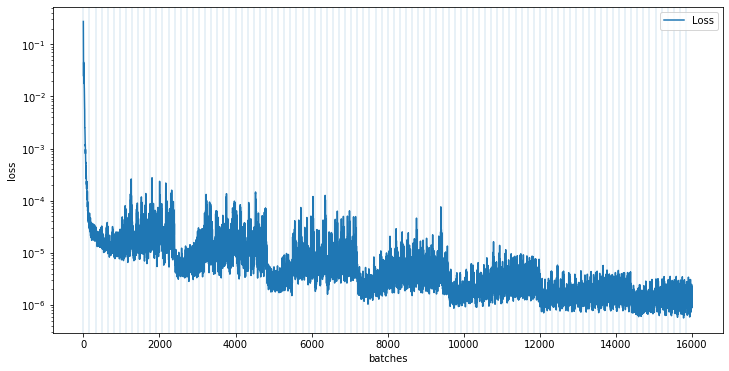

In [12]:
##################################################
#Plot loss for each batch after each epoch
timestr = time.strftime("%m%d")
epoch_lines = np.arange(0, epochs*batch, batch)
print(epoch_lines.shape)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'Loss')
plt.legend()
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.savefig('../Plots/Loss_' + timestr + '.png')
plt.show()

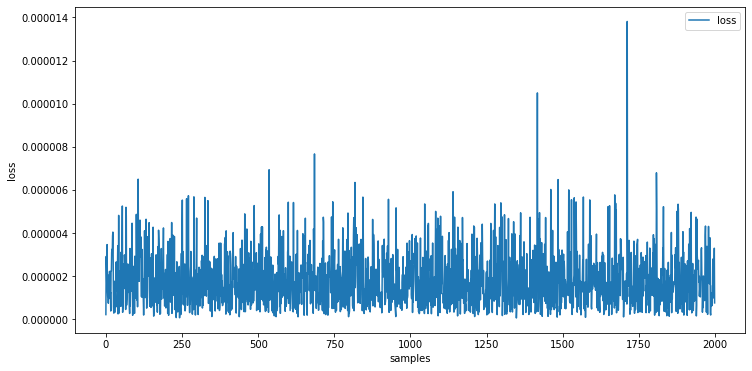

0.003651042963973339


In [13]:
####################################################
#Test the data
losses_test= []
with torch.no_grad():
    for i in range(samplenum_test):
        p_val = model(y_test[i, :])
        loss_test = criterion(p_val,p_test[i,:])
        losses_test.append(loss_test.clone().numpy())
#plot test errors
plt.figure(figsize = [12,6])
loss_test_plot = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('samples')
plt.show()
tot_error = sum(losses_test)
print(tot_error)


## PLOTS

In [14]:
#relative error
rel_errors_norm = []
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = np.linalg.norm((p_val - p_truth)/p_truth)
            rel_errors_norm.append(rel_error)

rel_errors_sum = torch.zeros(3*nTimeSteps)
abs_errors_sum = torch.zeros(3*nTimeSteps)
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(y_test[i, :])
            p_truth = p_test[i,:]
            rel_error = (p_val - p_truth)/p_truth
            abs_error = np.abs(p_val - p_truth)
            rel_errors_sum = rel_errors_sum + rel_error
            abs_errors_sum = abs_errors_sum + abs_error
x_err_rel = rel_errors_sum[0::3]/(samplenum_test)
y_err_rel = rel_errors_sum[1::3]/(samplenum_test)
z_err_rel = rel_errors_sum[2::3]/(samplenum_test)

x_err = abs_errors_sum[0::3]/(samplenum_test)
y_err = abs_errors_sum[1::3]/(samplenum_test)
z_err = abs_errors_sum[2::3]/(samplenum_test)

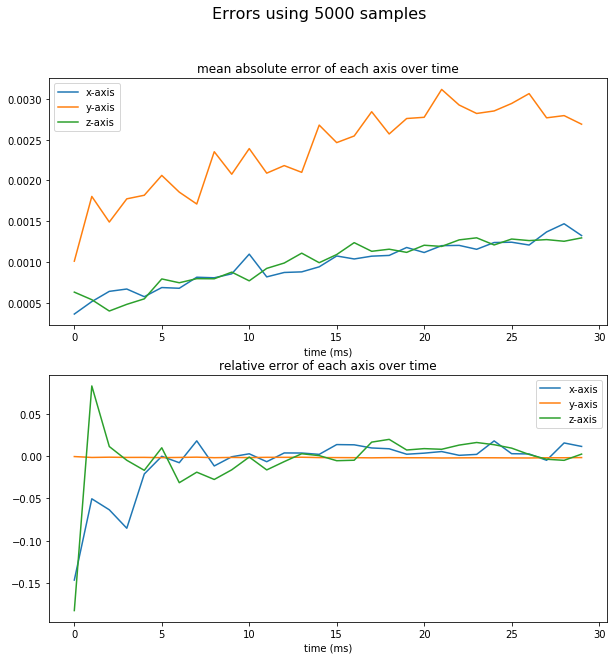

In [15]:
plt.figure(figsize = [10,10])
plt.suptitle('Errors using 5000 samples', fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(x_err_rel, label = 'x-axis')
plt.plot(y_err_rel, label = 'y-axis')
plt.plot(z_err_rel, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('relative error of each axis over time')
plt.legend()

plt.subplot(2, 1, 1)
plt.plot(x_err, label = 'x-axis')
plt.plot(y_err, label = 'y-axis')
plt.plot(z_err, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('mean absolute error of each axis over time')
plt.legend()
plt.show()

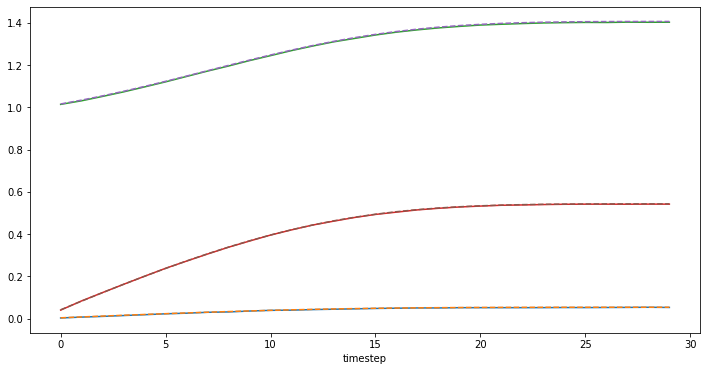

In [16]:
#x, y and z plot
randomsample = 9
with torch.no_grad():
        p_val = model(y_test[randomsample, :])
        p_truth = p_test[randomsample,:]
        x_val = p_val[0::3]
        y_val = p_val[1::3]
        z_val = p_val[2::3]
        x_truth = p_truth[0::3]
        y_truth = p_truth[1::3]
        z_truth = p_truth[2::3]
            

plt.figure(figsize = [12,6])
plt.plot(x_val)
plt.plot(x_truth, '--')
plt.plot(y_val)
plt.plot(z_val)
plt.plot(y_truth, '--')
plt.plot(z_truth, '--')

plt.xlabel('timestep')
plt.show()

In [20]:
#####################################################
#SAVE MODEL
timestr = time.strftime("%m%d")
#Save entire Model
torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model, model_file_path + 'Model_passive_' + use_case + '_{nTimeSteps}tsteps_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), model_file_path + 'state_dict/Trained_Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_passive_' + use_case + '_{nTimeSteps}tsteps_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = input[4, :]
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')
traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
print('Model saved')

Model saved


In [21]:
#####################################################
#TEST THE MODEL

# Generate simulation
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#Load objective
obj = dde.InverseObjective(dyn)

#obj.loadFile(objective_file_path)
data = json.load(open(objective_file_path))
data['objectives']['pmTargetPositions'][0]['targetPos'] = ([[0.5],[0.5],[0.5]])
obj.loadJson(data)

y_target_test_= torch.tensor([0.5, 0.5, 0.5])
p_ = model(y_target_test_)
p_ = p_.detach().numpy()
newton = dde.Newton()
p_truth_ = newton.minimize(obj, p_init)
y_target_ = y_target_test_.detach().numpy()

yTraj_test_ = dyn.q(p_)
yTraj_truth_ = dyn.q(p_truth_)

print('TEST OF THE MODEL')
print(f'\ntest for y_target:\n {y_target_test_}')
print(f'\nevaluated y_end:\n {yTraj_test_.q[-3:]}')
print(f'\nsimulated traj_opt y_end with p_truth:\n {yTraj_truth_.q[-3:]}')
print(f'\ndifference of y_end:\n {np.sum(yTraj_test_.q[-3:]-y_target_)}')
print(f'\nlast 6 entries of p predicted:\n {p_[-6:].transpose()}')
print(f'\nlast 6 entries of p from traj_opt:\n {p_truth_[-6:].transpose()}')

TEST OF THE MODEL

test for y_target:
 tensor([0.5000, 0.5000, 0.5000])

evaluated y_end:
 [0.49614707 0.49440524 0.49660688]

simulated traj_opt y_end with p_truth:
 [0.49715002 0.50034345 0.49715002]

difference of y_end:
 -0.012840816367857666

last 6 entries of p predicted:
 [0.55087745 1.1725949  0.55105054 0.5502675  1.1732128  0.5509958 ]

last 6 entries of p from traj_opt:
 [0.55128496 1.17671717 0.55128496 0.55131905 1.17671854 0.55131905]
